# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [0]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

### Change directory

In [23]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

### Load the training data from train.csv file

In [31]:
import pandas as pd

df=pd.read_csv("racoon_train_labels1.csv")

df.head()

,filename,width,height,xmin,ymin,xmax,ymax,class
0,raccoon-17.jpg,259,194,95,60,167,118,raccoon
1,raccoon-11.jpg,660,432,3,1,461,431,raccoon
2,raccoon-63.jpg,600,400,74,107,280,290,raccoon
3,raccoon-63.jpg,600,400,227,93,403,298,raccoon
4,raccoon-60.jpg,273,185,58,33,197,127,raccoon


### Print the shape of the train dataset

In [26]:
df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE=128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [68]:
DATASET_FOLDER = "/content/drive/My Drive/Colab Notebooks/"
TRAIN_CSV = DATASET_FOLDER+"racoon_train_labels1.csv"
images_zip_path = DATASET_FOLDER + "RacoonImages/"


import csv
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile), 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    for col, row in enumerate(reader):
        if(col==0):
          continue
        
        for i, r in enumerate(row[1:7]): # Parse row with seven entities
            row[i+1] = int(r)
              
        path,image_width,image_height,x0, y0, x1, y1,_ = row  
        #path = "./" + path.split('/')[-2] + "/" + path.split('/')[-1]
        #print(path)
        coords[col, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
        coords[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height
        paths.append(path)

coords=np.delete(coords,(0),axis=0)        
len(coords)

173

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [69]:

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/RacoonImages')
print(len(paths))
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
    
batch_images

173


array([[[[-0.18431371, -0.01176471, -0.10588235],
         [-0.9764706 , -0.8509804 , -0.92941177],
         [-0.92941177, -0.88235295, -0.9137255 ],
         ...,
         [ 0.17647064,  0.654902  ,  0.12941182],
         [-0.1607843 ,  0.2941177 , -0.02745098],
         [ 0.3411765 ,  0.7411765 ,  0.48235297]],

        [[-0.54509807, -0.38823527, -0.47450978],
         [-0.9843137 , -0.88235295, -0.9372549 ],
         [-0.827451  , -0.79607844, -0.8039216 ],
         ...,
         [-0.27058822,  0.18431377, -0.27843136],
         [-0.19215685,  0.26274514, -0.19215685],
         [ 0.0196079 ,  0.37254906,  0.12941182]],

        [[-0.7490196 , -0.62352943, -0.7019608 ],
         [-0.84313726, -0.75686276, -0.8039216 ],
         [-0.8352941 , -0.8039216 , -0.8117647 ],
         ...,
         [-0.32549018,  0.12156868, -0.4352941 ],
         [-0.25490195,  0.22352946, -0.5058824 ],
         [-0.17647058,  0.1686275 , -0.11372548]],

        ...,

        [[ 0.01176476,  0.33333337, -0

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1.0) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
gt = coords

def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

In [89]:

model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

model.fit(batch_images,gt,
            epochs=15,batch_size = 32,
            verbose=1)

Epoch 1/15
173/173 [==============================] - 7s 38ms/step - loss: 71.6293 - IoU: 0.8095
Epoch 2/15
173/173 [==============================] - 5s 30ms/step - loss: 67.6663 - IoU: 0.8225
Epoch 3/15
173/173 [==============================] - 5s 30ms/step - loss: 61.1752 - IoU: 0.8244
Epoch 4/15
173/173 [==============================] - 5s 31ms/step - loss: 62.7930 - IoU: 0.8236
Epoch 5/15
173/173 [==============================] - 5s 31ms/step - loss: 65.3323 - IoU: 0.8273
Epoch 6/15
173/173 [==============================] - 5s 31ms/step - loss: 59.6652 - IoU: 0.8313
Epoch 7/15
173/173 [==============================] - 5s 31ms/step - loss: 57.3063 - IoU: 0.8401
Epoch 8/15
173/173 [==============================] - 5s 31ms/step - loss: 61.5718 - IoU: 0.8383
Epoch 9/15
173/173 [==============================] - 5s 31ms/step - loss: 65.4187 - IoU: 0.8402
Epoch 10/15
173/173 [==============================] - 5s 31ms/step - loss: 54.6538 - IoU: 0.8476
Epoch 11/15
173/173 [========

### Pick a test image from the given data

In [0]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
filename = 'raccoon-77.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

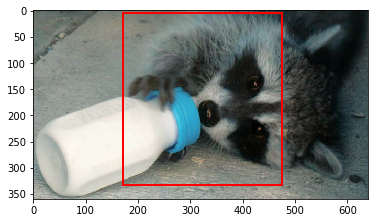

In [101]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [102]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### Change your present working directory

In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

### Load your data file

In [113]:
dfTemp=pd.read_csv("daily-minimum-temperatures-in-me.csv",index_col="Date")

dfTemp.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


#### Plot data

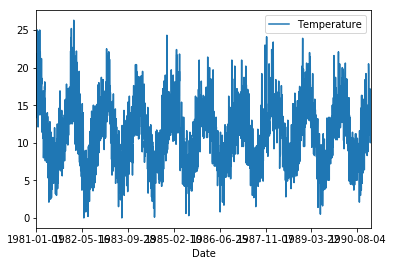

In [114]:
dfTemp.plot()

#### Descibe your dataframe

In [115]:
dfTemp.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [116]:
dfTemp.isnull().sum()

Temperature    0
dtype: int64

#### Drop null values

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f451e2da0>]],
      dtype=object)

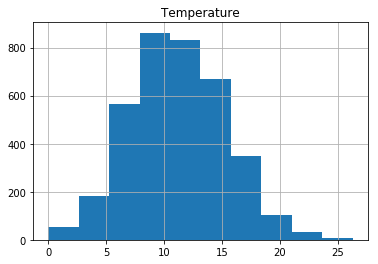

In [117]:
dfTemp.hist(bins=10)


#### Check the maximum and minimum values

In [118]:

# Scaled Data
print('Min', np.min(dfTemp))
print('Max', np.max(dfTemp))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [0]:
from sklearn.preprocessing import MinMaxScaler
dataset = dfTemp.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

#### Check the maximum and minimum values of scaled data

In [121]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [122]:
print(scaled[:10])

[[0.7870723 ]
 [0.68060837]
 [0.71482889]
 [0.55513311]
 [0.60076048]
 [0.60076048]
 [0.60076048]
 [0.66159696]
 [0.82889733]
 [0.7604563 ]]


### Split data into Training and Testing

In [123]:
#Sample
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


#### Print train and test size

In [124]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
#function to prepare Y as next months X value as this is Time Series
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [126]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806083702582986
1
X 1 to 2
[0.68060837]
Y 2
0.7148288890658444
2
X 2 to 3
[0.71482889]
Y 3
0.5551331104563756
3
X 3 to 4
[0.55513311]
Y 4
0.6007604809535642
4
X 4 to 5
[0.60076048]
Y 5
0.6007604809535642
5
X 5 to 6
[0.60076048]
Y 6
0.6007604809535642
6
X 6 to 7
[0.60076048]
Y 7
0.6615969628626882
7
X 7 to 8
[0.66159696]
Y 8
0.8288973334395067
8
X 8 to 9
[0.82889733]
Y 9
0.7604562958244149
9
X 9 to 10
[0.7604563]
Y 10
0.6159696286268815
10
X 10 to 11
[0.61596963]
Y 11
0.5057034439755123
11
X 11 to 12
[0.50570344]
Y 12
0.6349810360224919
12
X 12 to 13
[0.63498104]
Y 13
0.817490518011246
13
X 13 to 14
[0.81749052]
Y 14
0.9505703697805186
14
X 14 to 15
[0.95057037]
Y 15
0.7870722951873749
15
X 15 to 16
[0.7870723]
Y 16
0.7832699992037001
16
X 16 to 17
[0.78327]
Y 17
0.9429657778131689
17
X 17 to 18
[0.94296578]
Y 18
0.6730038508137127
18
X 18 to 19
[0.67300385]
Y 19
0.5893536292639215
19
X 19 to 20
[0.58935363]
Y 20
0.6920152582093231
20
X 20 to 21
[0.6

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [127]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers


#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.
#create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(1, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Summarize your model

In [131]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 1)                    12        
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [132]:
model.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/20
 - 6s - loss: 0.0780
Epoch 2/20
 - 4s - loss: 0.0213
Epoch 3/20
 - 4s - loss: 0.0171
Epoch 4/20
 - 4s - loss: 0.0153
Epoch 5/20
 - 4s - loss: 0.0141
Epoch 6/20
 - 4s - loss: 0.0132
Epoch 7/20
 - 4s - loss: 0.0124
Epoch 8/20
 - 4s - loss: 0.0120
Epoch 9/20
 - 4s - loss: 0.0112
Epoch 10/20
 - 4s - loss: 0.0110
Epoch 11/20
 - 4s - loss: 0.0106
Epoch 12/20
 - 4s - loss: 0.0105
Epoch 13/20
 - 4s - loss: 0.0105
Epoch 14/20
 - 4s - loss: 0.0104
Epoch 15/20
 - 4s - loss: 0.0105
Epoch 16/20
 - 4s - loss: 0.0105
Epoch 17/20
 - 4s - loss: 0.0104
Epoch 18/20
 - 4s - loss: 0.0104
Epoch 19/20
 - 4s - loss: 0.0103
Epoch 20/20
 - 4s - loss: 0.0104


## Make Predictions and Evaluate your model

In [133]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 2.47 RMSE


## Plot the results

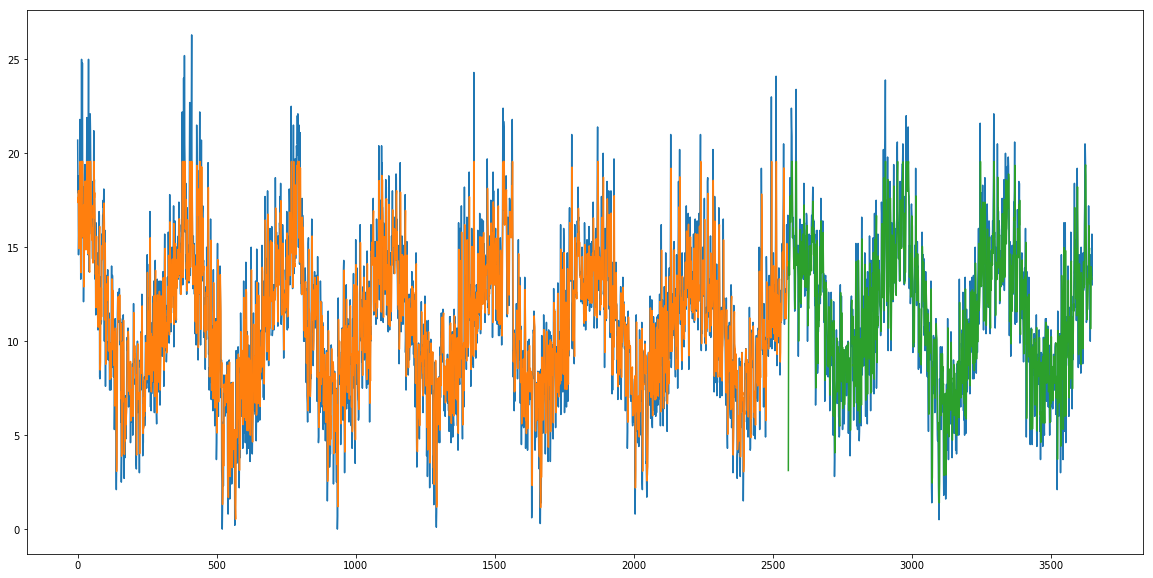

In [134]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()